In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Define the components of the path
base_path = '.'  # Represents the current directory
relative_path = 'data'
file_name = 'Online Retail.csv'

full_path = os.path.join(base_path, relative_path, file_name)

# Load data
df = pd.read_csv(full_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Analyze data
print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# Unique data of ID fields

df[['InvoiceNo', 'StockCode', 'CustomerID']].nunique().sort_values(ascending=False)

InvoiceNo     25900
CustomerID     4372
StockCode      4070
dtype: int64

In [5]:
# Check missing value
print(
    round(
        df.isnull().sum()/df.shape[0]*100, 3)
        .sort_values(ascending=False)
)

CustomerID     24.927
Description     0.268
InvoiceNo       0.000
StockCode       0.000
Quantity        0.000
InvoiceDate     0.000
UnitPrice       0.000
Country         0.000
dtype: float64


NOTES:
- Customer ID is difficult to guessed, Since our goals is to built cohort analysis and applied customer segmentation. It is better if we remove the customer ID to reduce bias.

- According to the data's field. Numerical field: 'Quantity' and 'UnitPrice', Date field: 'InvoiceDate', Id field: 'InvoiceNo', 'StockCode', and 'CustomerID', Text field: 'Description', and Categorical field: 'Country'

In [6]:
df = df.dropna(subset=['Description', 'CustomerID'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [7]:
# EDA Numerical Data

df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


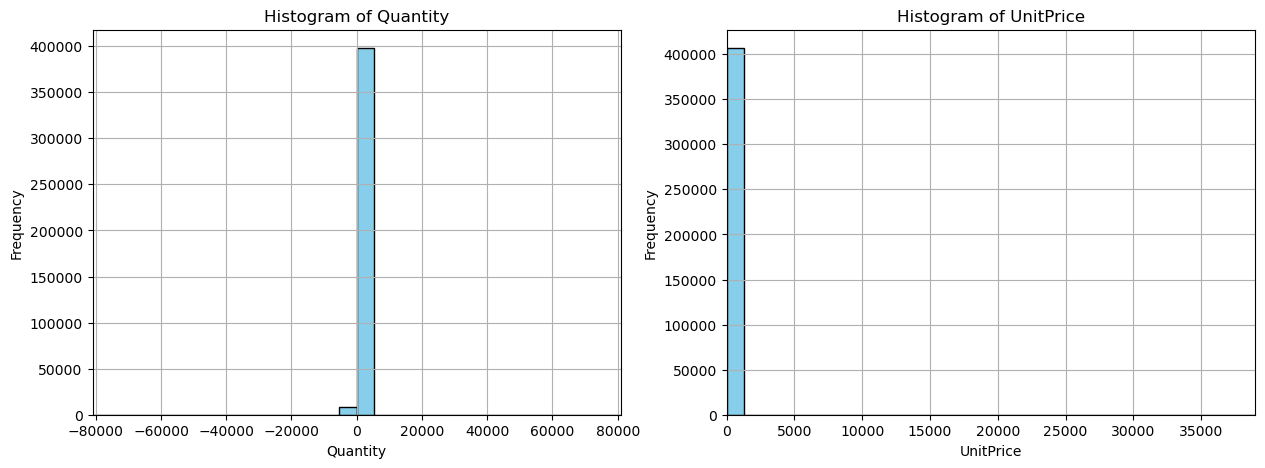

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


# Plot Distribution
def plot_hist(field, ax, n=30,):
    ax.hist(df[f'{field}'], bins=n, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {field}')
    ax.set_xlabel(f'{field}')
    ax.set_ylabel('Frequency')
    ax.set_xlim(min(df[f'{field}']), max(df[f'{field}']))
    ax.grid(True)

plot_hist('Quantity', ax=axes[0])
plot_hist('UnitPrice', ax=axes[1])
plt.show()


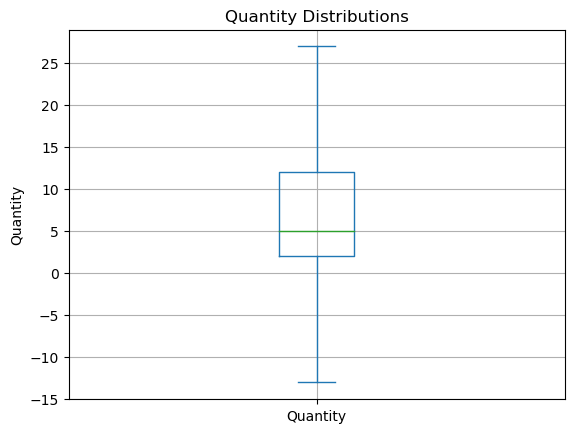

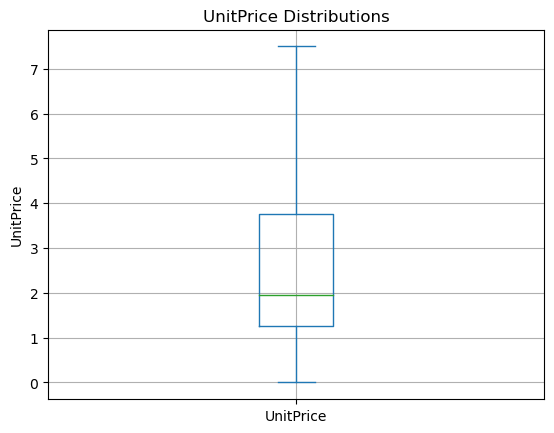

In [9]:
def boxplot(field):
    df[f'{field}'].plot.box(showfliers=False, grid=True)
    plt.ylabel(f'{field}')
    plt.title(f'{field} Distributions')
    plt.show()

boxplot('Quantity')
boxplot('UnitPrice')

In [10]:
# Detect Anomali
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = quantity_zero/df.shape[0] * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = unitprice_zero/df.shape[0] * 100


print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


In [11]:
# Remove anomali
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [12]:
# Format date

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M').dt.strftime("%Y-%m-%d %H:%M:%S")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
df = df.reset_index(drop=True)
df.to_csv('./result/online-retail-clean.csv', index_label='main_idx')

# Time Series Analysis

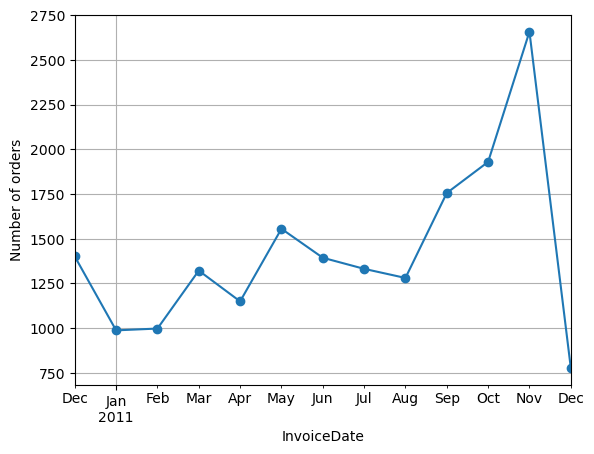

In [14]:
# Time Series
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df_monthly_orders = df[['InvoiceNo', 'InvoiceDate']]\
                    .set_index('InvoiceDate')\
                    .resample('M')\
                    .nunique()


df_monthly_orders.plot(grid=True, marker='o', legend=False)
plt.ylabel('Number of orders')
plt.show()

In [15]:
# Ensure the all data recorded is for the month that has passed
invoice_dec = df.loc[df['InvoiceDate'] >= '2011-12-01', 'InvoiceDate']
print(f'Min date: {invoice_dec.min()} \nMax date: {invoice_dec.max()}')

Min date: 2011-12-01 08:33:00 
Max date: 2011-12-09 12:50:00


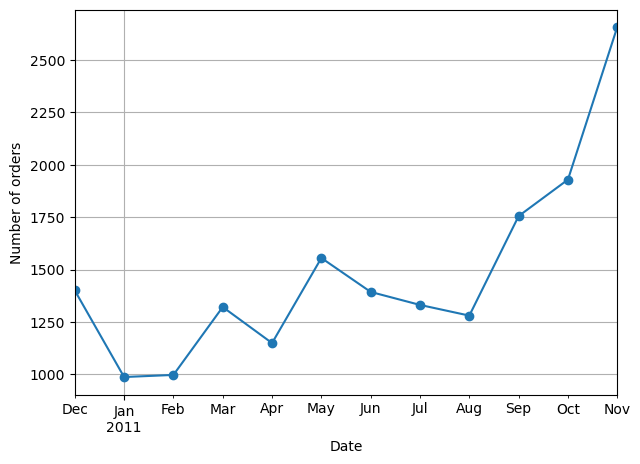

In [16]:
# Filter data
df = df.loc[df['InvoiceDate'] < '2011-12-01']

# Time Series
df_monthly_orders = df[['InvoiceNo', 'InvoiceDate']]\
                    .set_index('InvoiceDate')\
                    .resample('M')\
                    .nunique()


df_monthly_orders.plot(grid=True, marker='o', legend=False, figsize=(7, 5))
plt.ylabel('Number of orders')
plt.xlabel('Date')
plt.show()

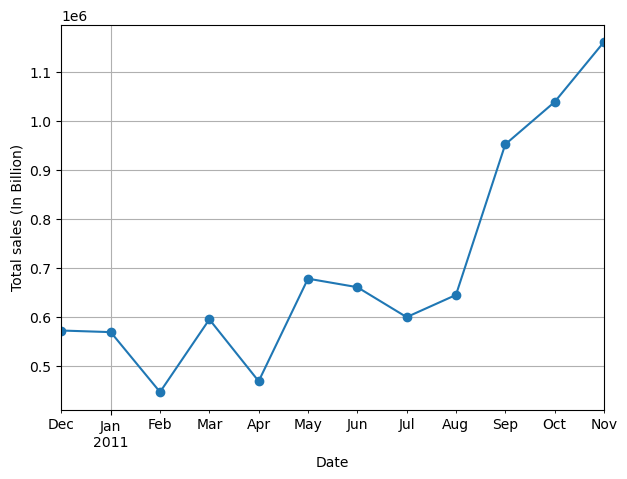

In [17]:
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

df_monthly_sales = df[['TotalSales', 'InvoiceDate']]\
                    .set_index('InvoiceDate')\
                    .resample('M')\
                    .sum()

df_monthly_sales.plot(grid=True, legend=False, marker='o', figsize=(7, 5))
plt.ylabel('Total sales (In Billion)')
plt.xlabel('Date')
plt.show()

# Repeat Customer and Purchase Rate

It focuses on customers with more than one invoice in a single month, thus identifying repeat customers based on the frequency of their transactions within the same month.

In [18]:
# Repeat Customer Rate

# First groupby the data according its InvoiceNo and InvoiceDate.
# The aggregations are sum of sales, max CustomerID and country (only select the maximum ones). 
df_invoice_customers = df.groupby(by=['InvoiceNo', 'InvoiceDate'])\
                    .agg({'TotalSales': sum,'CustomerID': max, 'Country': max,})\
                    .reset_index()

# Second we can groupby the df_invoice_customers on the CustomerID, 
# then we select the customer who purchase more than 1 in each month
monthly_repeat_customers = df_invoice_customers\
                            .set_index('InvoiceDate')\
                            .groupby([ pd.Grouper(freq='M'), 'CustomerID'])\
                            .filter(lambda x: len(x) > 1)\
                            .resample('M')\
                            .nunique()['CustomerID']

monthly_repeat_customers

InvoiceDate
2010-12-31    263
2011-01-31    153
2011-02-28    152
2011-03-31    203
2011-04-30    170
2011-05-31    281
2011-06-30    220
2011-07-31    227
2011-08-31    198
2011-09-30    272
2011-10-31    324
2011-11-30    541
Freq: M, Name: CustomerID, dtype: int64

In [19]:
# Third, we select all the customer in each month.
monthly_unique_customers = df.set_index('InvoiceDate')['CustomerID'].resample('M').nunique()

monthly_unique_customers

InvoiceDate
2010-12-31     885
2011-01-31     741
2011-02-28     758
2011-03-31     974
2011-04-30     856
2011-05-31    1056
2011-06-30     991
2011-07-31     949
2011-08-31     935
2011-09-30    1266
2011-10-31    1364
2011-11-30    1664
Freq: M, Name: CustomerID, dtype: int64

In [20]:
# Last, we calculate the percentage of customer who made transactions more than one and total customers in each month.
monthly_repeat_percentage = (monthly_repeat_customers / monthly_unique_customers) * 100.0
monthly_repeat_percentage

InvoiceDate
2010-12-31    29.717514
2011-01-31    20.647773
2011-02-28    20.052770
2011-03-31    20.841889
2011-04-30    19.859813
2011-05-31    26.609848
2011-06-30    22.199798
2011-07-31    23.919916
2011-08-31    21.176471
2011-09-30    21.484992
2011-10-31    23.753666
2011-11-30    32.512019
Freq: M, Name: CustomerID, dtype: float64

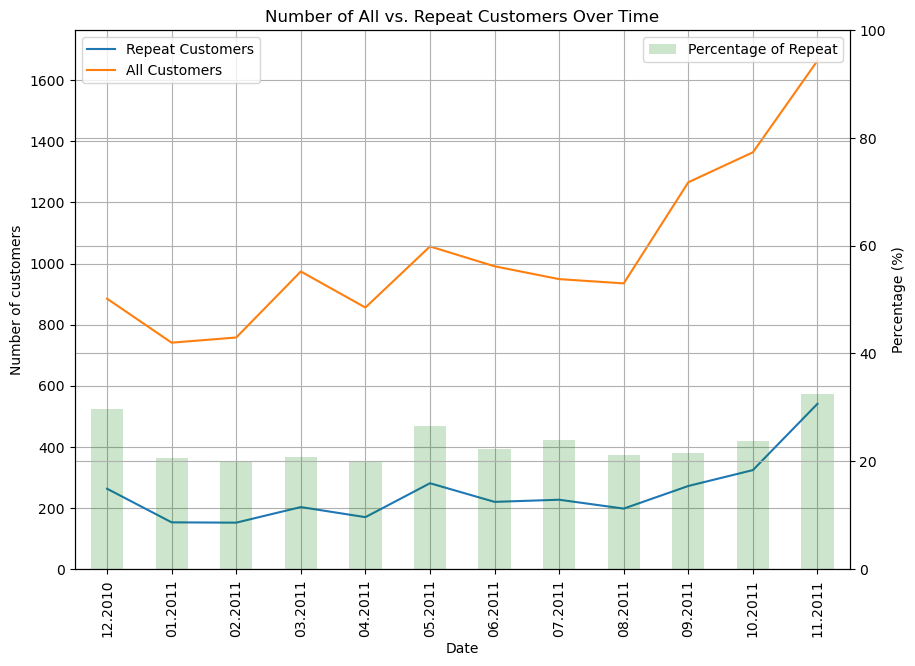

In [21]:
# The first frame (Will plot the time series of number of customer each month)
ax = pd.DataFrame(monthly_repeat_customers.values).plot(
    figsize=(10,7)
)

pd.DataFrame(monthly_unique_customers.values).plot(
    ax=ax,
    grid=True
)

ax.set_xlabel('Date')
ax.set_ylabel('Number of customers')
ax.set_title('Number of All vs. Repeat Customers Over Time')
ax.set_ylim([0, monthly_unique_customers.values.max()+100])


# The second frame (Will plot Repeat Customer Rate)
ax2 = pd.DataFrame(monthly_repeat_percentage.values).plot.bar(
    ax=ax,
    grid=True,
    secondary_y=True,
    color='green',
    alpha=0.2
)

ax2.set_ylabel('Percentage (%)')
ax.legend(['Repeat Customers', 'All Customers'])
ax2.legend(['Percentage of Repeat'], loc='upper right')
ax2.set_ylim([0, 100])

plt.xticks(
    range(len(monthly_repeat_customers.index)), 
    [x.strftime('%m.%Y') for x in monthly_repeat_customers.index], 
    rotation=45
)

plt.show()

In [22]:
# df_repeat_customer = monthly_repeat_customers.reset_index()
df_repeat_customer = pd.merge(monthly_unique_customers, monthly_repeat_customers, right_index=True, left_index=True)
df_repeat_customer = df_repeat_customer.join(monthly_repeat_percentage)
df_repeat_customer.reset_index(inplace=True)
df_repeat_customer.columns = ['date', 'count_customers', 'count_repeat_customers', 'repeat_customer_rate']
# df_repeat_customer.to_csv('repeat-customer.csv', index=False)
df_repeat_customer

,date,count_customers,count_repeat_customers,repeat_customer_rate
0,2010-12-31,885,263,29.717514
1,2011-01-31,741,153,20.647773
2,2011-02-28,758,152,20.052770
3,2011-03-31,974,203,20.841889
4,2011-04-30,856,170,19.859813
5,2011-05-31,1056,281,26.609848
6,2011-06-30,991,220,22.199798
7,2011-07-31,949,227,23.919916
8,2011-08-31,935,198,21.176471
9,2011-09-30,1266,272,21.484992


In [23]:
# Repeat Purchase Rate

# First calculate total purchase from repeat customers each month.
monthly_rev_repeat_customers = df_invoice_customers\
                                .set_index('InvoiceDate')\
                                .groupby([pd.Grouper(freq='M'), 'CustomerID'])\
                                .filter(lambda x: len(x) > 1)\
                                .resample('M')\
                                .agg({"TotalSales":'sum'})['TotalSales']

monthly_rev_repeat_customers

InvoiceDate
2010-12-31    359170.60
2011-01-31    222124.00
2011-02-28    191067.27
2011-03-31    267390.48
2011-04-30    195474.18
2011-05-31    378197.04
2011-06-30    376307.26
2011-07-31    317475.00
2011-08-31    317134.25
2011-09-30    500663.36
2011-10-31    574006.87
2011-11-30    713775.85
Freq: M, Name: TotalSales, dtype: float64

In [24]:
# Second calculate monthly total sales
monthly_sales = df.set_index('InvoiceDate')['TotalSales'].resample('M').sum()
monthly_sales

InvoiceDate
2010-12-31     572713.890
2011-01-31     569445.040
2011-02-28     447137.350
2011-03-31     595500.760
2011-04-30     469200.361
2011-05-31     678594.560
2011-06-30     661213.690
2011-07-31     600091.011
2011-08-31     645343.900
2011-09-30     952838.382
2011-10-31    1039318.790
2011-11-30    1161817.380
Freq: M, Name: TotalSales, dtype: float64

In [25]:
# Third calculate Repeat Purchase Rate
monthly_rev_perc_repeat_customers = (monthly_rev_repeat_customers / monthly_sales) * 100.0
monthly_rev_perc_repeat_customers

InvoiceDate
2010-12-31    62.713792
2011-01-31    39.007101
2011-02-28    42.731226
2011-03-31    44.901787
2011-04-30    41.661132
2011-05-31    55.732401
2011-06-30    56.911595
2011-07-31    52.904475
2011-08-31    49.141899
2011-09-30    52.544416
2011-10-31    55.229144
2011-11-30    61.436148
Freq: M, Name: TotalSales, dtype: float64

In [26]:
df_repeat_purchase = pd.merge(monthly_sales, monthly_rev_repeat_customers, right_index=True, left_index=True)
df_repeat_purchase = df_repeat_purchase.join(monthly_rev_perc_repeat_customers)
df_repeat_purchase.reset_index(inplace=True)
df_repeat_purchase.columns = ['date', 'total_sales', 'total_repeat_sales', 'repeat_purchase_rate']
# df_repeat_purchase.to_csv('repeat-purchase.csv', index=False)
df_repeat_purchase

,date,total_sales,total_repeat_sales,repeat_purchase_rate
0,2010-12-31,572713.890,359170.60,62.713792
1,2011-01-31,569445.040,222124.00,39.007101
2,2011-02-28,447137.350,191067.27,42.731226
3,2011-03-31,595500.760,267390.48,44.901787
4,2011-04-30,469200.361,195474.18,41.661132
5,2011-05-31,678594.560,378197.04,55.732401
6,2011-06-30,661213.690,376307.26,56.911595
7,2011-07-31,600091.011,317475.00,52.904475
8,2011-08-31,645343.900,317134.25,49.141899
9,2011-09-30,952838.382,500663.36,52.544416


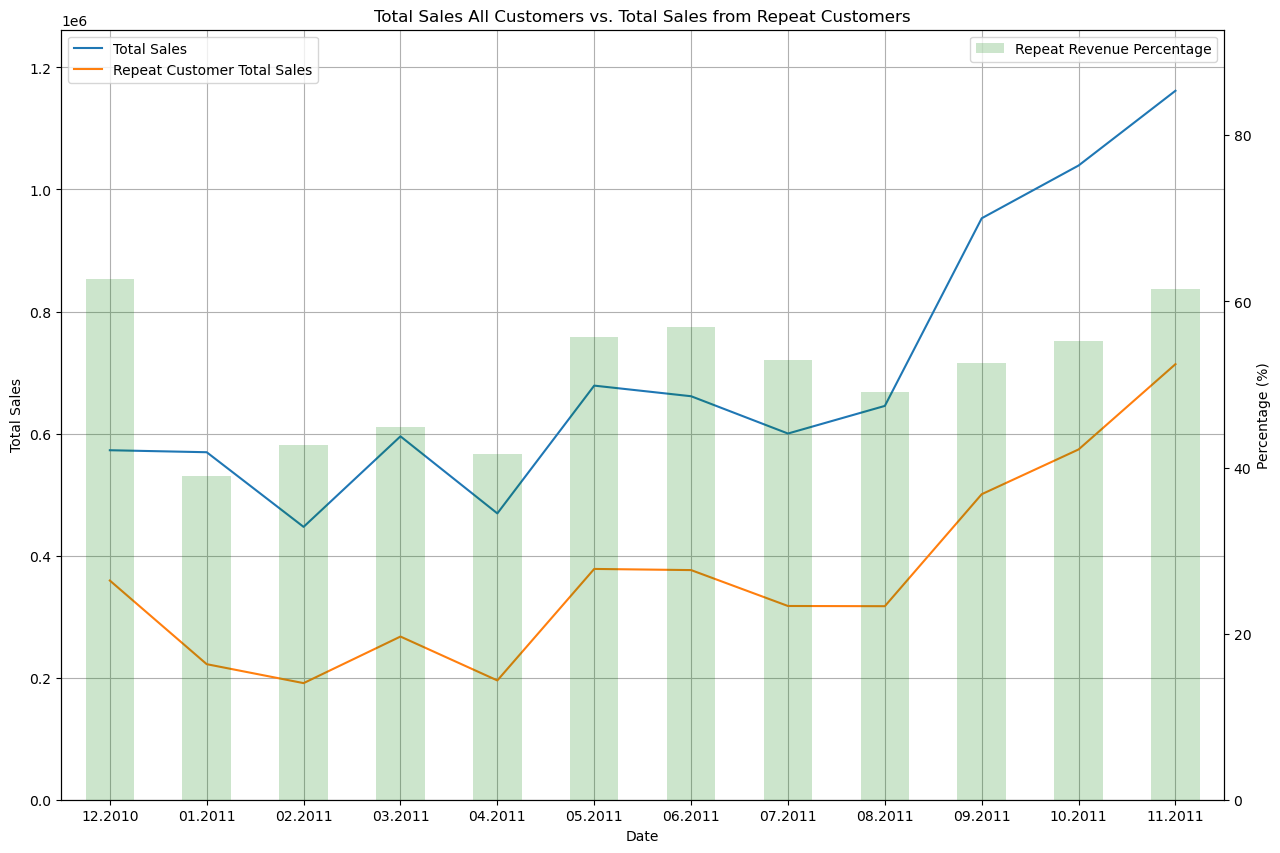

In [27]:
# The first frame (Will plot the time series of total sales each month)
ax = pd.DataFrame(df_monthly_sales.values).plot(figsize=(15,10))

pd.DataFrame(monthly_rev_repeat_customers.values).plot(
    ax=ax,
    grid=True,
)

ax.set_xlabel('Date')
ax.set_ylabel('Total Sales')
ax.set_title('Total Sales All Customers vs. Total Sales from Repeat Customers')
ax.legend(['Total Sales', 'Repeat Customer Total Sales'], loc='upper left')
ax.set_ylim([0, max(df_monthly_sales.values)+100000])

# The second frame (Will plot Repeat Purchase Rate)
ax2 = ax.twinx()

pd.DataFrame(monthly_rev_perc_repeat_customers.values).plot(
    ax=ax2,
    kind='bar',
    color='g',
    alpha=0.2
)

ax2.set_ylim([0, max(monthly_rev_perc_repeat_customers.values)+30])
ax2.set_ylabel('Percentage (%)')
ax2.legend(['Repeat Revenue Percentage'], loc='upper right')

plt.xticks(
    range(len(monthly_rev_perc_repeat_customers.index)), 
    [x.strftime('%m.%Y') for x in monthly_rev_perc_repeat_customers.index], 
)

plt.show()

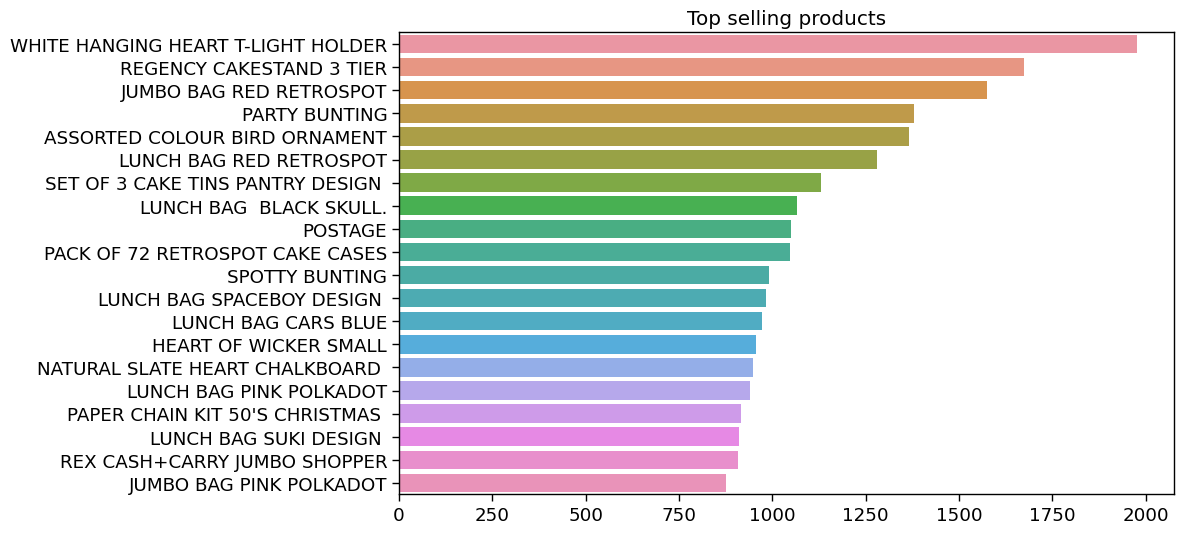

In [28]:
# Let's visualize some top products from the whole range.
top_products = df['Description'].value_counts()[:20]
plt.figure(figsize=(10,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values)
plt.title("Top selling products")
plt.show();

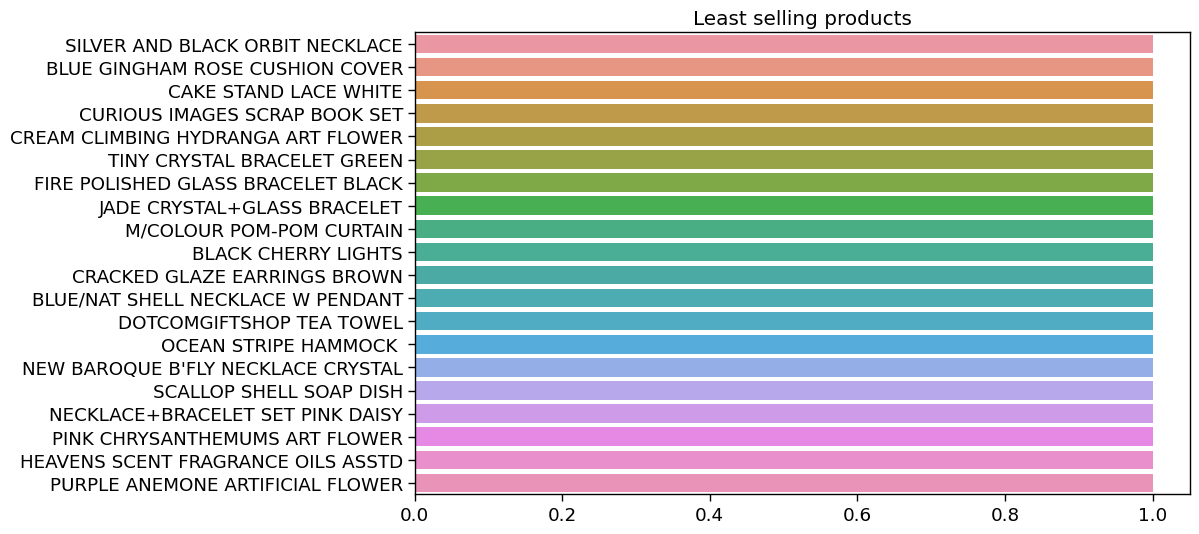

In [29]:
# Let's visualize some Least selling products from the whole range.
least_products = df['Description'].value_counts().sort_values(ascending=True)[:20]
plt.figure(figsize=(10,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = least_products.index,
            x = least_products.values)
plt.title("Least selling products")
plt.show();

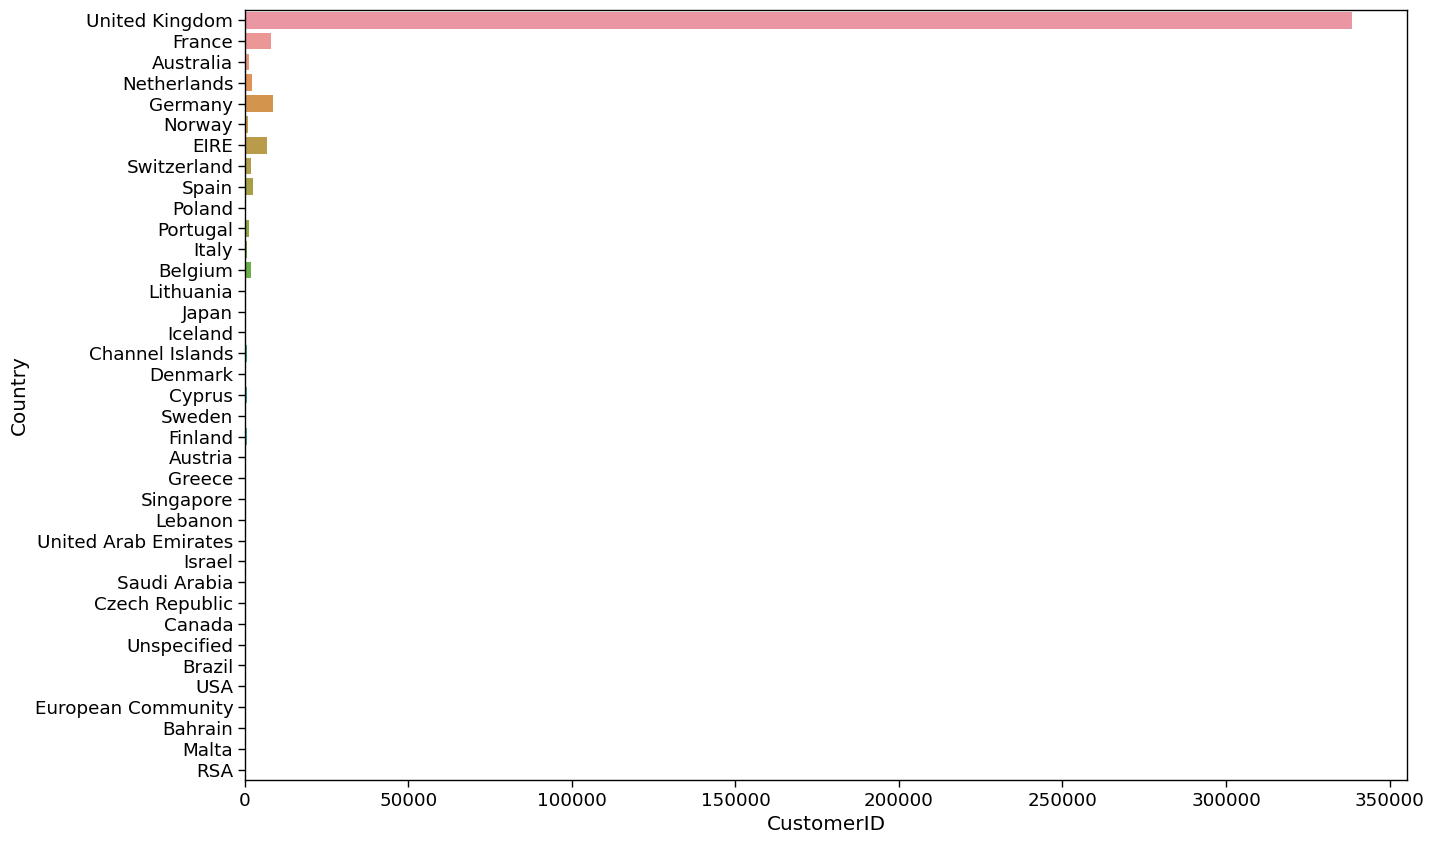

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(y = 'Country', x = 'CustomerID', data=df, estimator=np.count_nonzero, ax=ax)
plt.show()

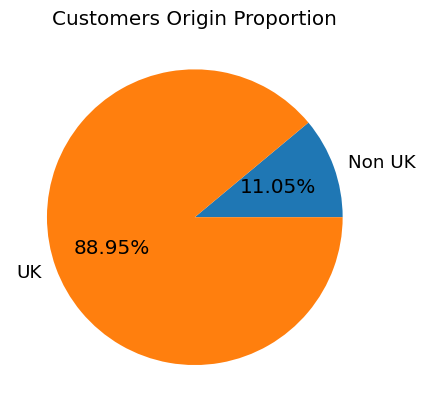

In [31]:
df['Country_isUK'] = np.where(df['Country'] == 'United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show()

In [32]:
# Monthly cohort analysis groups customers into cohorts based on their first purchase month
# and then tracks their subsequent behavior over time.

# Create the cohort based on the first purchase date
cohort_data = df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
cohort_data.rename(columns = {'InvoiceDate':'CohortDate'}, inplace=True)

# Extract year and month from CohortDate and InvoiceDate
cohort_data['CohortYearMonth'] = cohort_data['CohortDate'].dt.to_period('M')
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')


# Merge the cohort dataframe with the cleaned data
merged_cohort = pd.merge(df, cohort_data, on='CustomerID')

# Calculate the difference in months for the CohortIndex
merged_cohort['CohortIndex'] = (
    (merged_cohort['InvoiceYearMonth'].dt.year - merged_cohort['CohortYearMonth'].dt.year) * 12 +
    (merged_cohort['InvoiceYearMonth'].dt.month - merged_cohort['CohortYearMonth'].dt.month)
)

# Count monthly active customers from each cohort
cohort_counts = merged_cohort.groupby(['CohortYearMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# Create a pivot table with CohortYearMonth as rows, CohortIndex as columns, and CustomerID counts as values
cohort_pivot = cohort_counts.pivot(index='CohortYearMonth', columns='CohortIndex', values='CustomerID')

cohort_pivot.head()  # Display the first few rows of the cohort pivot table


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11
CohortYearMonth,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,NaN,NaN,NaN,NaN


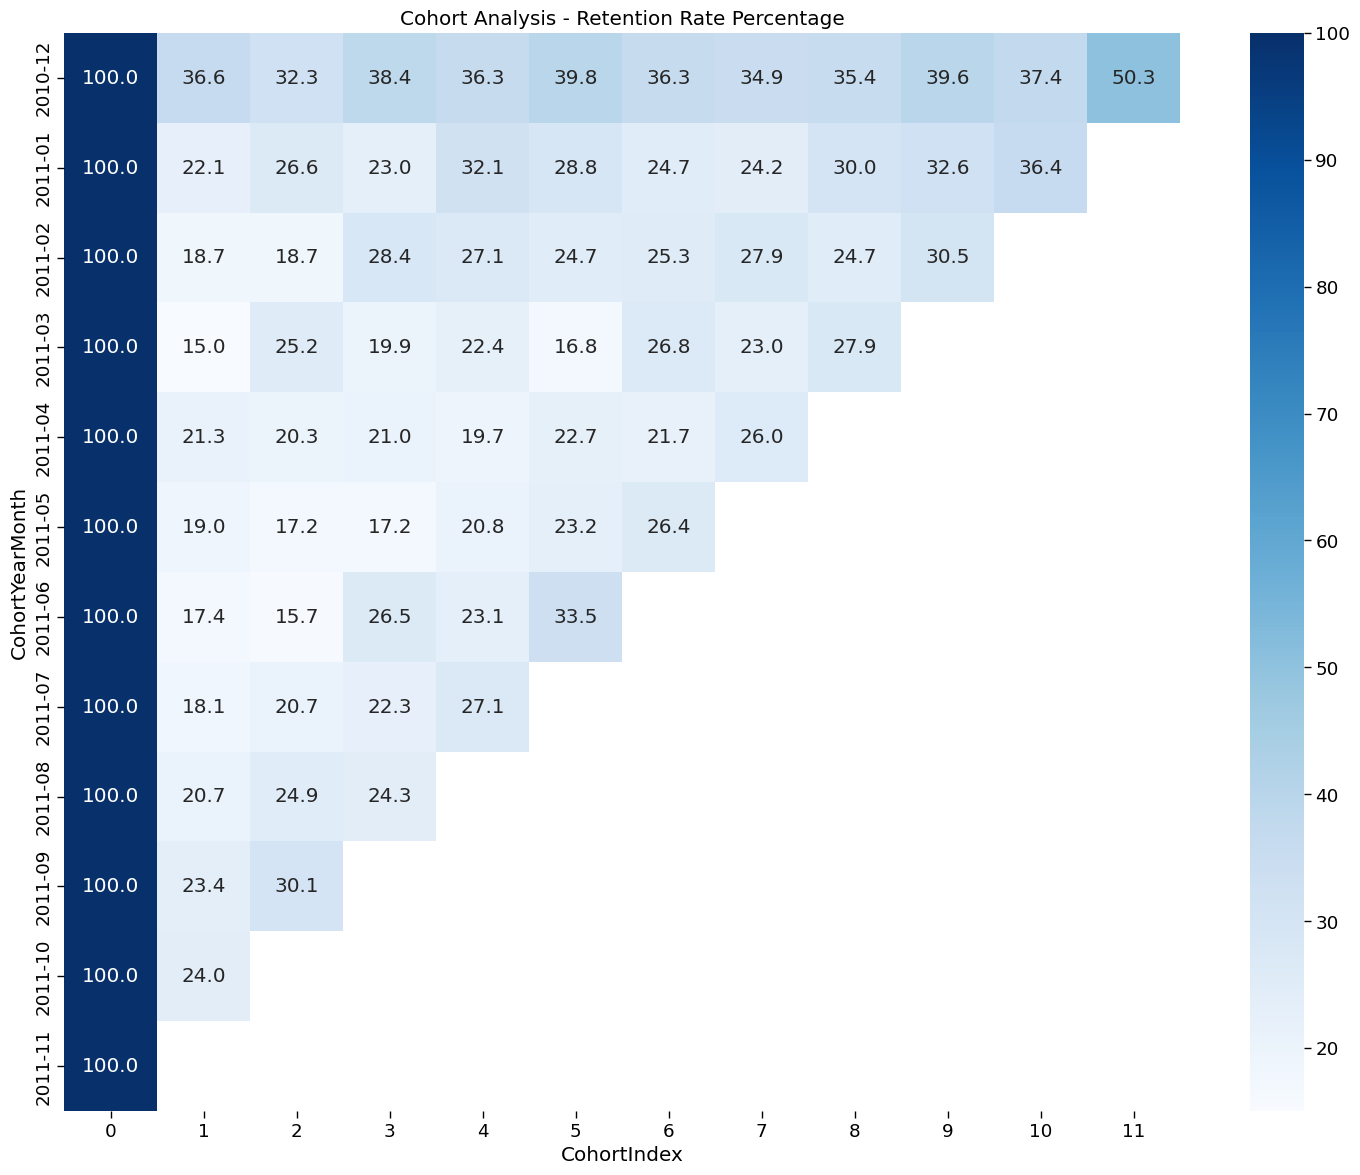

In [33]:
# To generate the retention rates as percentages, we will first need to calculate the total number of customers in the first month of the cohort.
# Then, we will divide the number of active customers in each subsequent month by the initial cohort size.

# Calculate initial cohort sizes (total number of customers in the first month of the cohort)
cohort_sizes = cohort_pivot.iloc[:,0]

# Calculate retention as a percentage
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0)

# Convert the retention matrix into percentage format
retention_matrix_percentage = retention_matrix.round(4) * 100


plt.figure(figsize=(18, 14))
plt.title('Cohort Analysis - Retention Rate Percentage')
sns.heatmap(data=retention_matrix_percentage, annot=True, fmt='.1f', cmap='Blues')
plt.show()


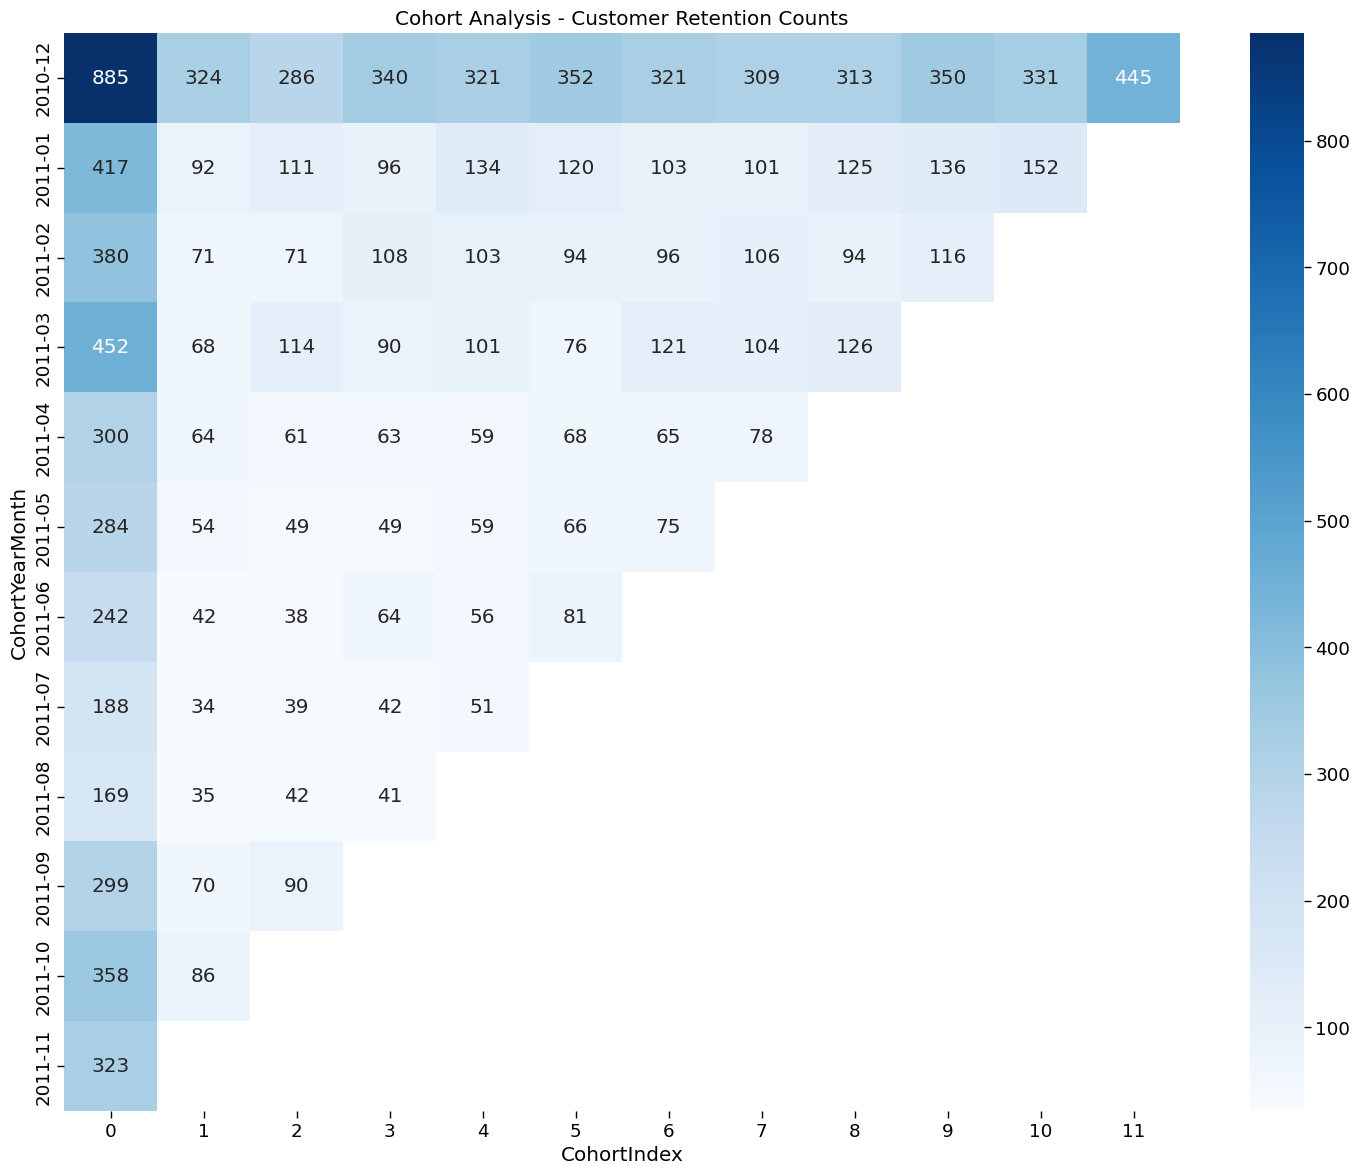

In [34]:
# We will now plot the actual customer retention counts from the cohort analysis.
# This is the actual number of customers from each cohort who made a purchase in subsequent months.

plt.figure(figsize=(18, 14))
plt.title('Cohort Analysis - Customer Retention Counts')
sns.heatmap(data=cohort_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.show()


In [35]:
# cohort_pivot.to_csv('./result/customer_retention.csv', index=True)
# retention_matrix_percentage.to_csv('./result/customer_retention_perc.csv', index=True)

In [36]:
# Count monthly active customers from each cohort
cohort_revenue = merged_cohort.groupby(['CohortYearMonth', 'CohortIndex'])['TotalSales'].sum().reset_index()

# Create a pivot table with CohortYearMonth as rows, CohortIndex as columns, and CustomerID counts as values
cohort_pivot = cohort_revenue.pivot(index='CohortYearMonth', columns='CohortIndex', values='TotalSales')

cohort_pivot.head()  # Display the first few rows of the cohort pivot table


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11
CohortYearMonth,,,,,,,,,,,,
2010-12,572713.890,276237.69,233845.37,303119.39,204407.66,336627.50,314162.61,310783.92,331749.220,472813.64,456080.61,513803.59
2011-01,293207.350,55149.91,63268.17,71587.40,81114.09,84583.78,70107.40,72689.71,72023.651,111803.90,123882.10,NaN
2011-02,158142.070,29043.24,41134.38,48238.86,40147.91,34223.23,49706.63,62450.83,55380.060,64809.45,NaN,NaN
2011-03,200069.960,30059.43,59057.51,42816.61,51657.33,40020.81,64919.49,71023.95,71265.830,NaN,NaN,NaN
2011-04,122011.491,29452.82,25077.07,24311.47,26314.19,30206.30,28668.98,34228.61,NaN,NaN,NaN,NaN


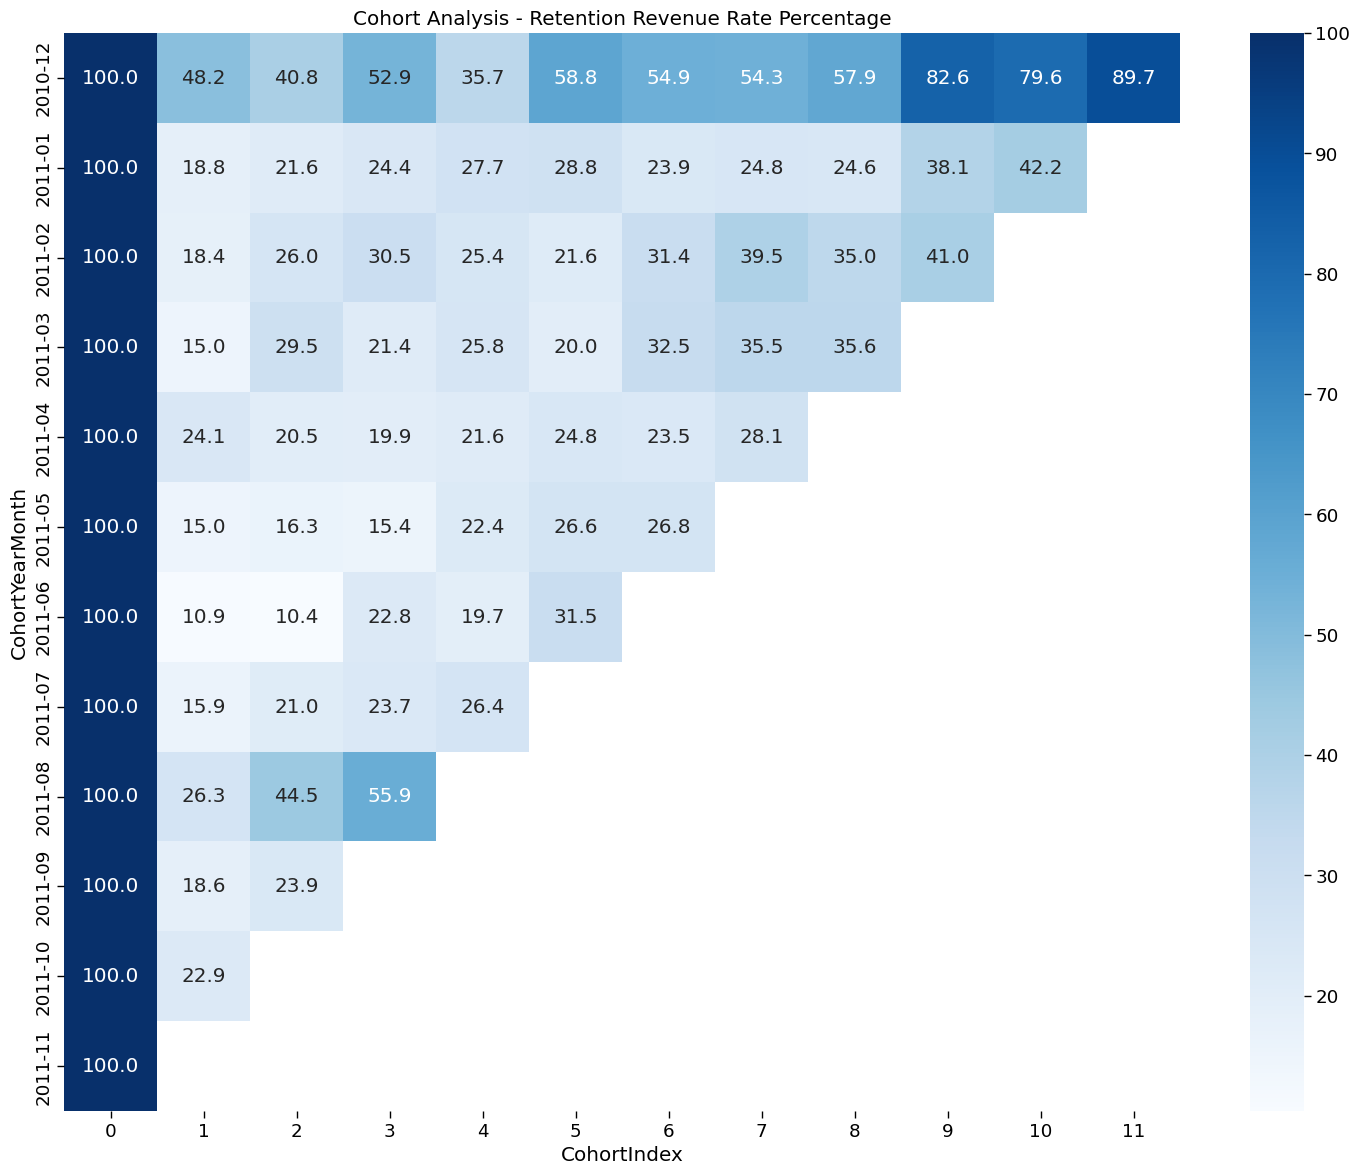

In [37]:
# To generate the retention rates as percentages, we will first need to calculate the total number of customers in the first month of the cohort.
# Then, we will divide the number of active customers in each subsequent month by the initial cohort size.

# Calculate initial cohort sizes (total number of customers in the first month of the cohort)
cohort_sizes = cohort_pivot.iloc[:,0]

# Calculate retention as a percentage
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0)

# Convert the retention matrix into percentage format
retention_matrix_percentage = retention_matrix.round(4) * 100


plt.figure(figsize=(18, 14))
plt.title('Cohort Analysis - Retention Revenue Rate Percentage')
sns.heatmap(data=retention_matrix_percentage, annot=True, fmt='.1f', cmap='Blues')
plt.show()


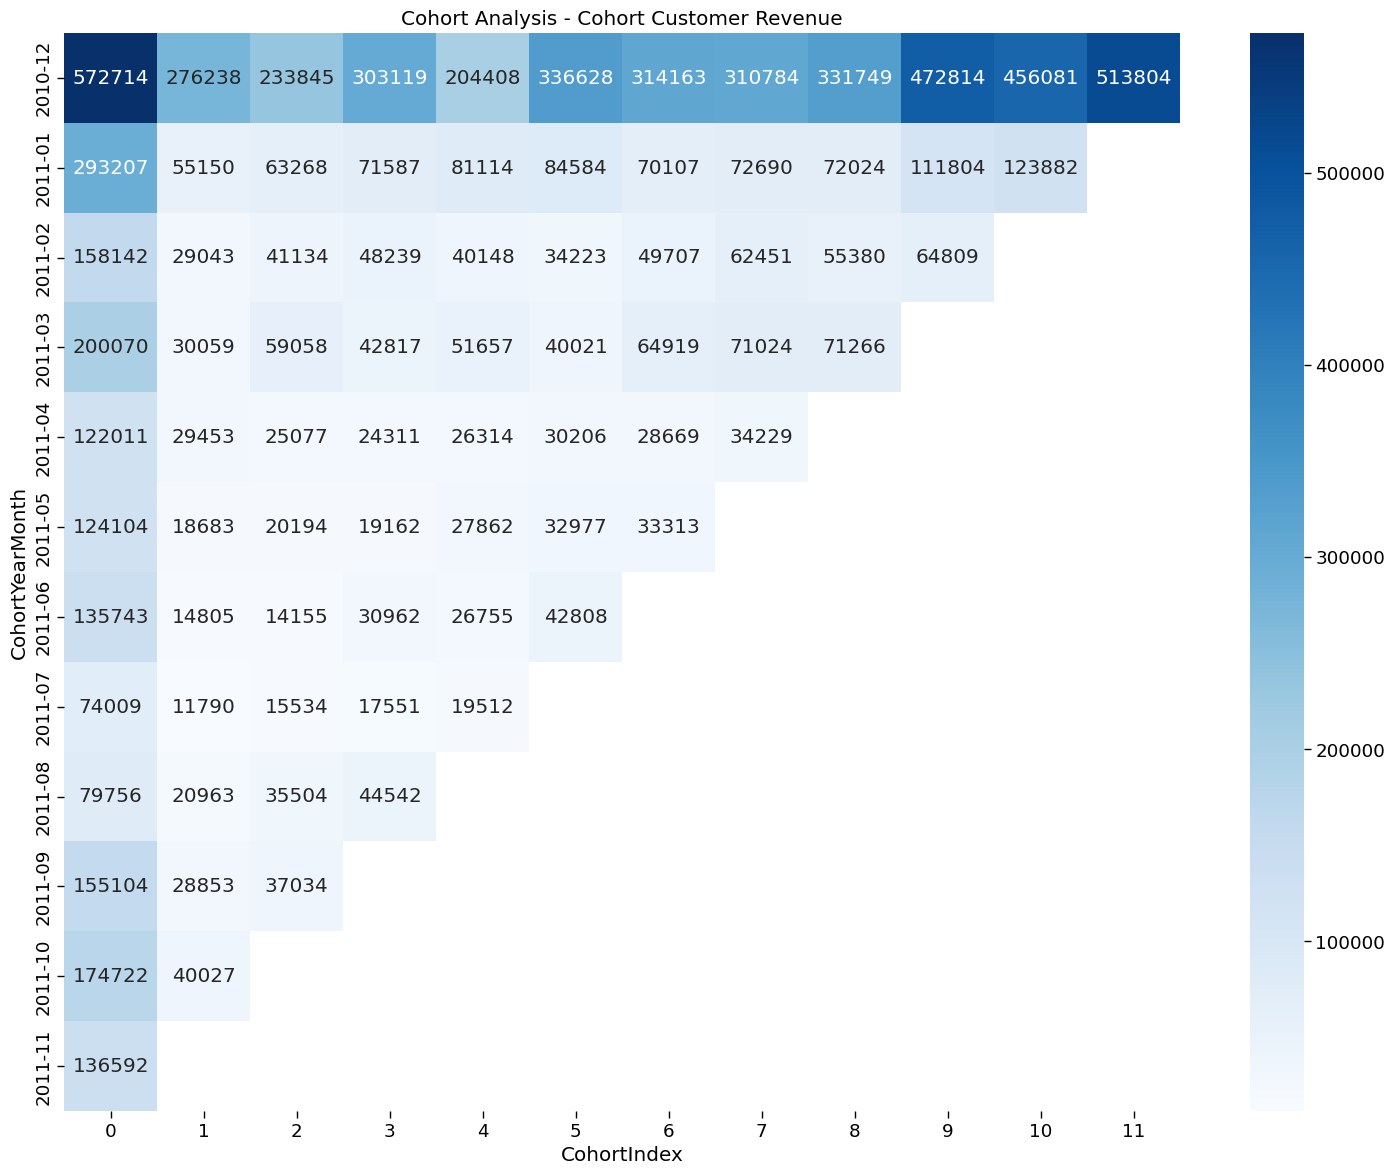

In [38]:
# We will now plot the actual customer retention counts from the cohort analysis.
# This is the actual number of customers from each cohort who made a purchase in subsequent months.

plt.figure(figsize=(18, 14))
plt.title('Cohort Analysis - Cohort Customer Revenue')
sns.heatmap(data=cohort_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.show()


# RFM Analysis - Ranking Based Method

In [39]:
# RFM Analysis (Ranking-Based Method or Quartile method approximation)

df['date'] = pd.DatetimeIndex(df['InvoiceDate']).date
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Country_isUK,InvoiceYearMonth,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,UK,2010-12,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,UK,2010-12,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,UK,2010-12,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,UK,2010-12,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,UK,2010-12,2010-12-01


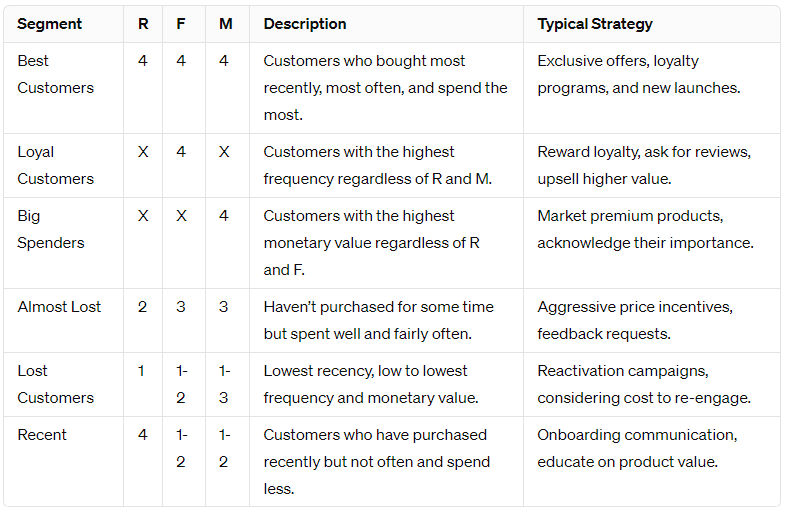

In [40]:
now = df['date'].max() + pd.Timedelta(days=1)
recency = df.groupby(['CustomerID'])['date'].max().reset_index()
recency.columns = ['CustomerID', 'LastPurchase']
recency['Recency'] = recency['LastPurchase'].apply(lambda x: (now - x).days)
recency.drop('LastPurchase', axis=1, inplace=True)

recency.head()

,CustomerID,Recency
0,12346.0,317
1,12347.0,31
2,12348.0,67
3,12349.0,10
4,12350.0,302


In [41]:
frequency = df.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep='first')\
            .groupby(['CustomerID'])['InvoiceDate']\
            .count()\
            .reset_index()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,6
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [42]:
monetary = df.groupby(['CustomerID']).agg({'TotalSales':'sum'}).reset_index()
monetary.columns = ['CustomerID','Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4085.18
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [43]:
rfm_table = df.groupby(['CustomerID']).size().reset_index().drop(0, axis=1)

# Merge the data
rfm_table = rfm_table \
    .merge(recency, on = 'CustomerID') \
    .merge(frequency, on = 'CustomerID') \
    .merge(monetary, on = 'CustomerID')

# Set CustomerID as index
rfm_table = rfm_table.set_index('CustomerID')

rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,317,1,77183.60
12347.0,31,6,4085.18
12348.0,67,4,1797.24
12349.0,10,1,1757.55
12350.0,302,1,334.40


In [44]:
rfm_table.describe()

,Recency,Frequency,Monetary
count,4297.000000,4297.000000,4297.000000
mean,91.481499,4.131720,1953.273240
std,98.577826,7.412705,8355.832473
min,1.000000,1.000000,2.900000
25%,16.000000,1.000000,304.470000
50%,50.000000,2.000000,657.300000
75%,146.000000,4.000000,1600.860000
max,365.000000,200.000000,268478.000000


The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

Note: Quintiles (score from 1-5) offer better granularity, in case the business needs that but it will be more challenging to create segments since we will have 555 possible combinations. So, we will use quartiles.

In [45]:
quantiles = rfm_table.quantile(q=[0.25, 0.5, 0.75])
quantiles

,Recency,Frequency,Monetary
0.25,16.0,1.0,304.47
0.50,50.0,2.0,657.30
0.75,146.0,4.0,1600.86


In [46]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [47]:
#create rfm segmentation table
rfm_segmentation = rfm_table.copy()
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346.0,317,1,77183.60,1,1,4
12347.0,31,6,4085.18,3,4,4
12348.0,67,4,1797.24,2,3,4
12349.0,10,1,1757.55,4,1,4
12350.0,302,1,334.40,1,1,2


In [48]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346.0,317,1,77183.60,1,1,4,114
12347.0,31,6,4085.18,3,4,4,344
12348.0,67,4,1797.24,2,3,4,234
12349.0,10,1,1757.55,4,1,4,414
12350.0,302,1,334.40,1,1,2,112


In [49]:
def classification(score):
    if score == '444':
        return 'Best Customers'
    if score[1] == '4':
        return 'Loyal Customers'
    if score[2] == '4':
        return 'Big Spenders'
    if score[0] == '4':
        return 'Recent Customers'
    if score == '233':
        return 'Almost Lost'
    if score[0] == '1':
        return 'Lost Customers'
#     if (score[0] == '1') and\
#         (score[1] == '2' or score[1] == '1') and\
#         (score[2] == '3' or score[2] == '2' or score[2] == '1' ):
#             return 'Lost Customers'
#     if (score[0] == '4') and\
#         (score[1] == '2' or score[1] == '1') and\
#         (score[2] == '2' or score[2] == '1'):
#             return 'Recent Customers'


rfm_segmentation['Cluster'] = rfm_segmentation['RFMScore'].apply(classification)


In [50]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  433
Loyal Customers:  1056
Big Spenders:  1074
Almost Lost:  100
Lost Customers:  14
Lost Cheap Customers:  442


<Figure size 1000x600 with 0 Axes>

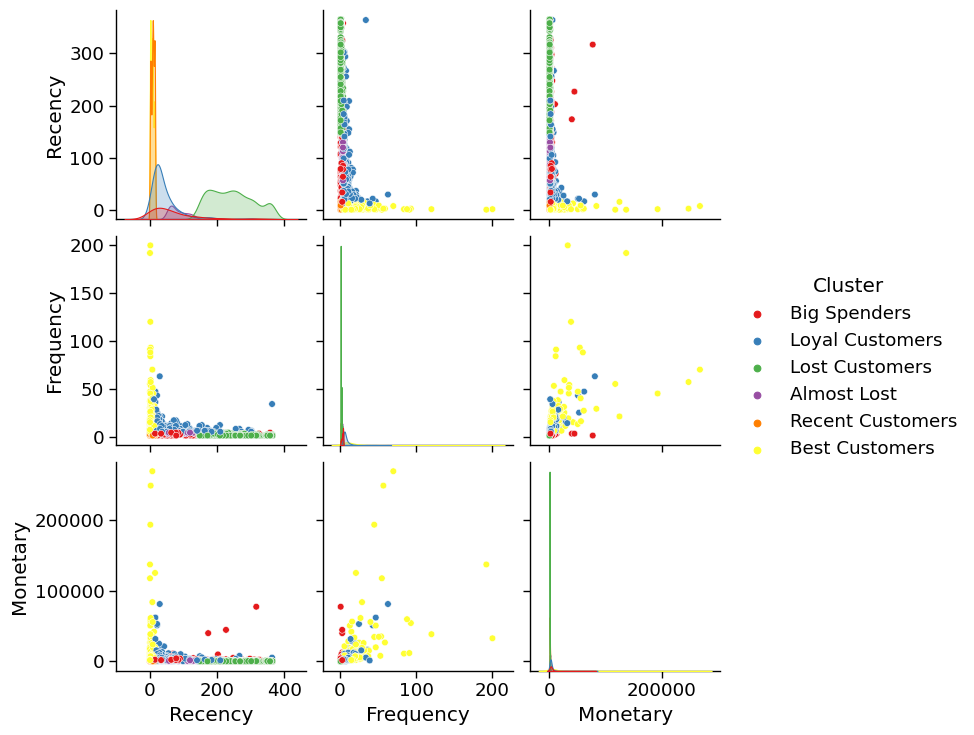

In [51]:
# Create a scatter plot with color-coding for segments
plt.figure(figsize=(10, 6))
sns.pairplot(
    data=rfm_segmentation[['Recency', 'Frequency', 'Monetary', 'Cluster']],
    hue='Cluster',
    palette='Set1',  
)
# plt.title('Customer Segmentation Scatter Plot')
plt.xlabel('Recency')
plt.ylabel('Frequency')
# plt.xticks(rotation=90)
# plt.legend(title='Segment', loc='upper right')
plt.show()

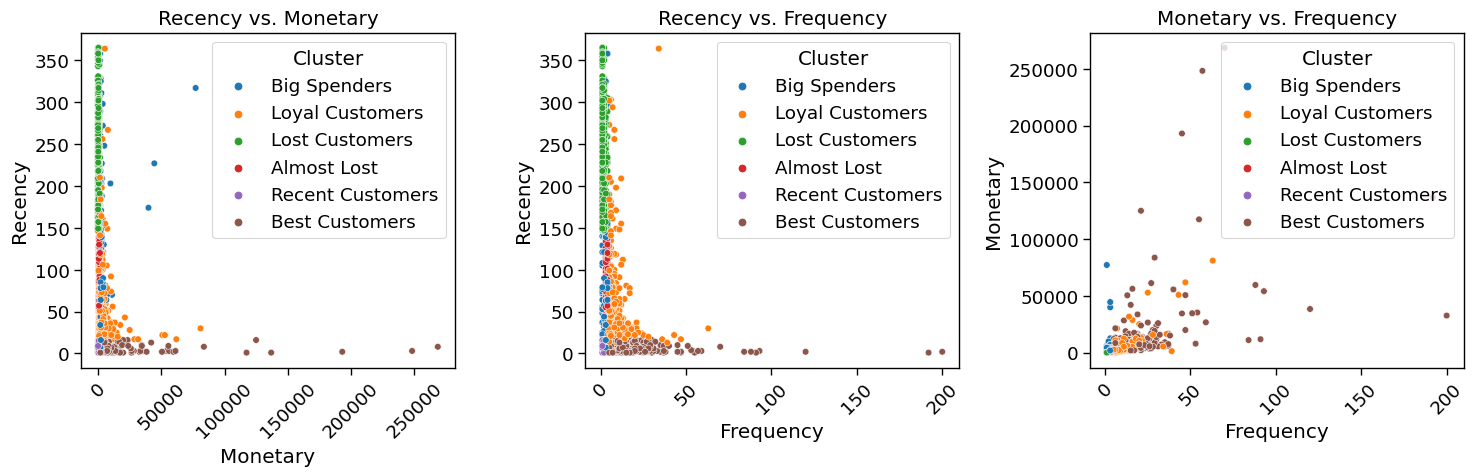

In [52]:
# Create subplots for boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colors for the bars
colors = ['lightblue', 'lightcoral', 'lightgreen']

# Boxplot of Cluster vs. Recency
sns.scatterplot(x='Frequency', y='Recency', hue='Cluster', data=rfm_segmentation, ax=axes[1])
axes[1].set_title('Recency vs. Frequency')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Recency')
axes[1].tick_params(axis='x', labelrotation=45)


# # Boxplot of Cluster vs. Frequency
sns.scatterplot(x='Monetary', y='Recency', hue='Cluster', data=rfm_segmentation, ax=axes[0])
axes[0].set_title('Recency vs. Monetary')
axes[0].set_xlabel('Monetary')
axes[0].set_ylabel('Recency')
axes[0].tick_params(axis='x', labelrotation=45)


# # Boxplot of Cluster vs. Monetary
sns.scatterplot(x='Frequency', y='Monetary',hue='Cluster', data=rfm_segmentation, ax=axes[2],)
axes[2].set_title('Monetary vs. Frequency')
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Monetary')
axes[2].tick_params(axis='x', labelrotation=45)



# Adjust layout
plt.tight_layout()

# Show the boxplots
plt.show()

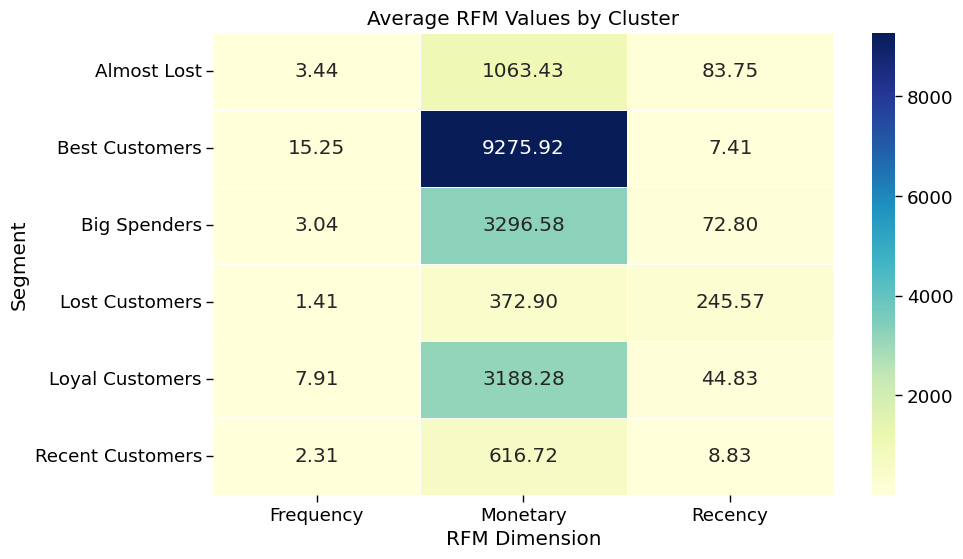

In [53]:
# Create a pivot table with the reordered segment order
pivot_table = rfm_segmentation.pivot_table(
    values=['Recency', 'Frequency', 'Monetary'],
    index='Cluster',
    aggfunc='mean'
)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    annot=True,  # Display values in each cell
    cmap='YlGnBu',  # Choose a color map
    fmt='.2f',  # Format for displaying values
    linewidths=0.5,  # Add linewidths between cells
)
plt.title('Average RFM Values by Cluster')
plt.xlabel('RFM Dimension')
plt.ylabel('Segment')
plt.show()

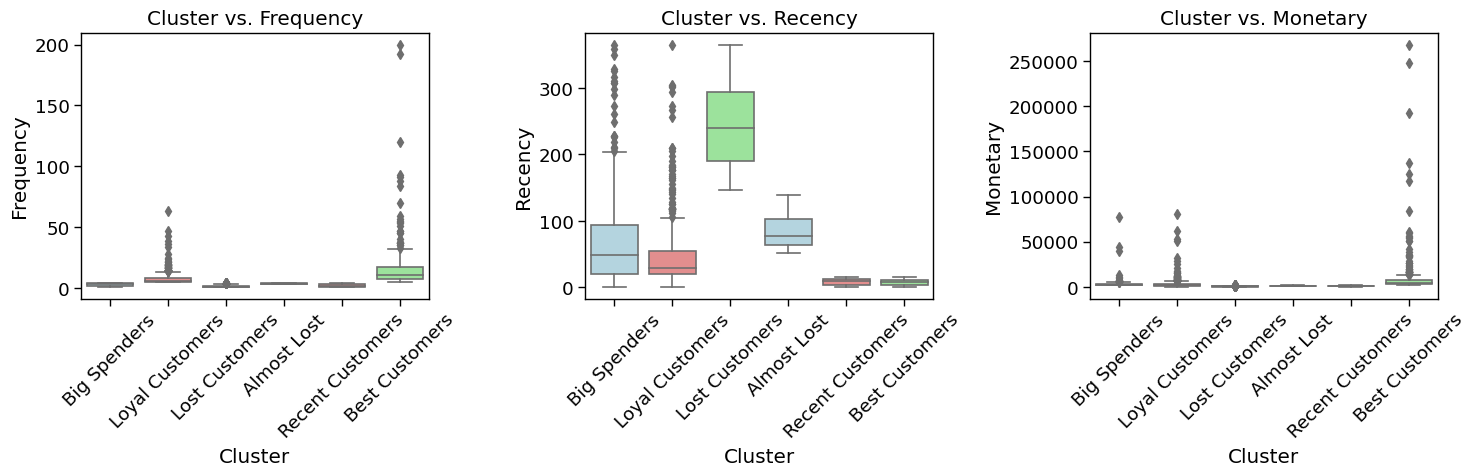

In [54]:
# Create subplots for boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colors for the bars
colors = ['lightblue', 'lightcoral', 'lightgreen']

# Boxplot of Cluster vs. Recency
sns.boxplot(x='Cluster', y='Recency', data=rfm_segmentation, ax=axes[1], palette=colors)
axes[1].set_title('Cluster vs. Recency')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Recency')
axes[1].tick_params(axis='x', labelrotation=45)


# Boxplot of Cluster vs. Frequency
sns.boxplot(x='Cluster', y='Frequency', data=rfm_segmentation, ax=axes[0], palette=colors)
axes[0].set_title('Cluster vs. Frequency')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', labelrotation=45)


# Boxplot of Cluster vs. Monetary
sns.boxplot(x='Cluster', y='Monetary', data=rfm_segmentation, ax=axes[2], palette=colors)
axes[2].set_title('Cluster vs. Monetary')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Monetary')
axes[2].tick_params(axis='x', labelrotation=45)



# Adjust layout
plt.tight_layout()

# Show the boxplots
plt.show()

# RFM Analysis - KMeans Approximation

C:\Users\Baha Tegar\AppData\Local\Temp\ipykernel_17036\1650366777.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_table.Recency , color="dodgerblue", ax=axes[0], axlabel='Recency')
C:\Users\Baha Tegar\AppData\Local\Temp\ipykernel_17036\1650366777.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

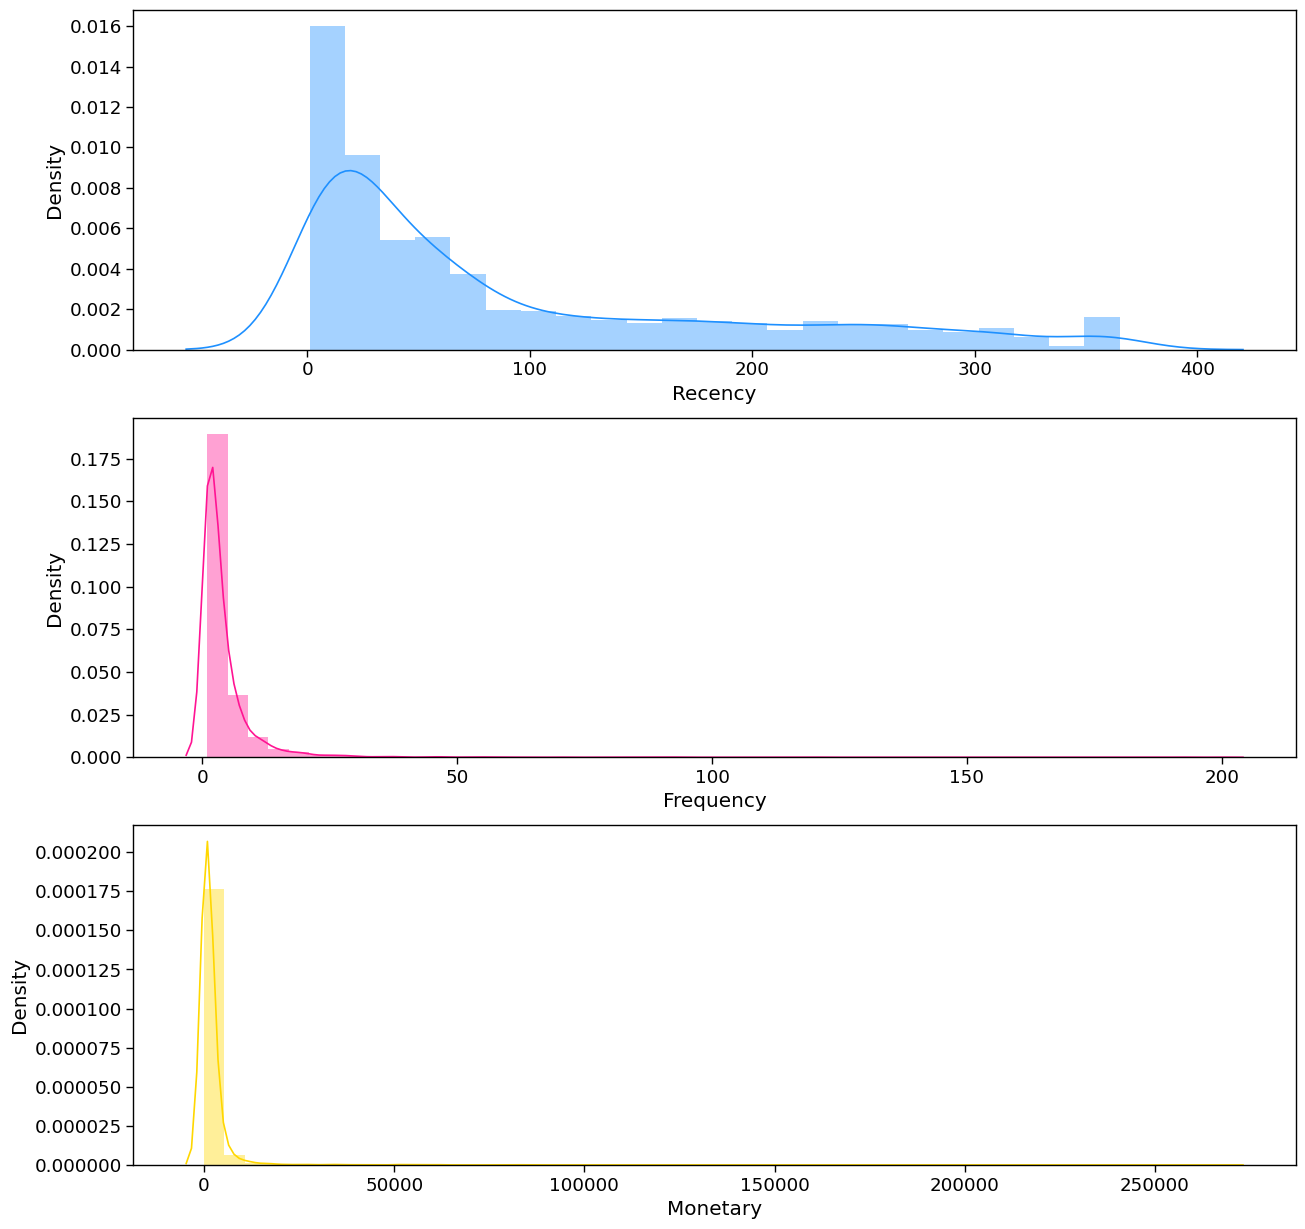

In [55]:
# RFM with K-Means

# plot
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(rfm_table.Recency , color="dodgerblue", ax=axes[0], axlabel='Recency')
sns.distplot(rfm_table.Frequency , color="deeppink", ax=axes[1], axlabel='Frequency')
sns.distplot(rfm_table.Monetary , color="gold", ax=axes[2], axlabel='Monetary')
# plt.xlim(50,75);
plt.show();

In [56]:
rfm_table.describe()

,Recency,Frequency,Monetary
count,4297.000000,4297.000000,4297.000000
mean,91.481499,4.131720,1953.273240
std,98.577826,7.412705,8355.832473
min,1.000000,1.000000,2.900000
25%,16.000000,1.000000,304.470000
50%,50.000000,2.000000,657.300000
75%,146.000000,4.000000,1600.860000
max,365.000000,200.000000,268478.000000


Here we can observe that the data is highly skewed. So we have to transform and scale the data first because K-Means assumes that the variables should have a symmetric distributions(not skewed) and they should have same average values as well as same variance.

In [81]:
# # Scale the data

# scaler = StandardScaler()
# scaler.fit(rfm_table)

StandardScaler()

In [83]:
import pickle
# Save the model to a file
with open('./model/kmeans_clustering_scaler.pkl', 'wb') as model_file:
    pickle.dump(scaler, model_file)

In [84]:
with open('./model/kmeans_clustering_scaler.pkl', 'rb') as model_file:
    scaler = pickle.load(model_file)

scaler

StandardScaler()

In [82]:
rfm_table_scaled = scaler.transform(rfm_table)
rfm_table_scaled = pd.DataFrame(rfm_table_scaled, columns = rfm_table.columns, index = rfm_table.index)

rfm_table_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.287987,-0.422529,9.004379
12347.0,-0.613612,0.252067,0.255170
12348.0,-0.248376,-0.017772,-0.018676
12349.0,-0.826666,-0.422529,-0.023426
12350.0,2.135805,-0.422529,-0.193764


In [58]:
rfm_table_scaled.describe()

,Recency,Frequency,Monetary
count,4.297000e+03,4.297000e+03,4.297000e+03
mean,1.653579e-18,-6.614315e-18,1.653579e-18
std,1.000116e+00,1.000116e+00,1.000116e+00
min,-9.179755e-01,-4.225292e-01,-2.334418e-01
25%,-7.657938e-01,-4.225292e-01,-1.973466e-01
50%,-4.208485e-01,-2.876100e-01,-1.551161e-01
75%,5.531147e-01,-1.777153e-02,-4.218063e-02
max,2.774968e+00,2.642640e+01,3.190056e+01


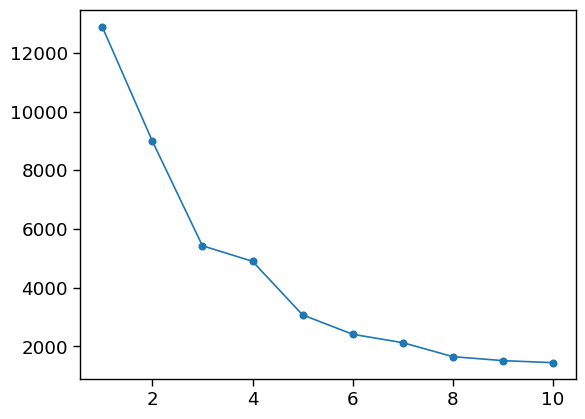

In [59]:
# find WCSS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(rfm_table_scaled)
    wcss.append(kmeans.inertia_)

# plot elbow graph
plt.plot(range(1,11),wcss,marker='o');

From the elbow graph, it seems that good number of cluster would be either 2 or 3 as after that, its a smooth curve i.e. no change of orientation. but to overcome that confusion, we will use silhouette score method to find the optimum number of clusters because it is often much better in figuring out the number of valid clusters than the elbow method

Silhouette score for number of cluster(s) 2: 0.8965339950311592
Silhouette score for number of cluster(s) 3: 0.5787498961262922
Silhouette score for number of cluster(s) 4: 0.5897029032052571
Silhouette score for number of cluster(s) 5: 0.5945483774234321
Silhouette score for number of cluster(s) 6: 0.5892806504487047
Silhouette score for number of cluster(s) 7: 0.5208658029774077
Silhouette score for number of cluster(s) 8: 0.4820345726923115
Silhouette score for number of cluster(s) 9: 0.48307626488597033
Silhouette score for number of cluster(s) 10: 0.41725468794722975
Silhouette score for number of cluster(s) 11: 0.4194584689575448


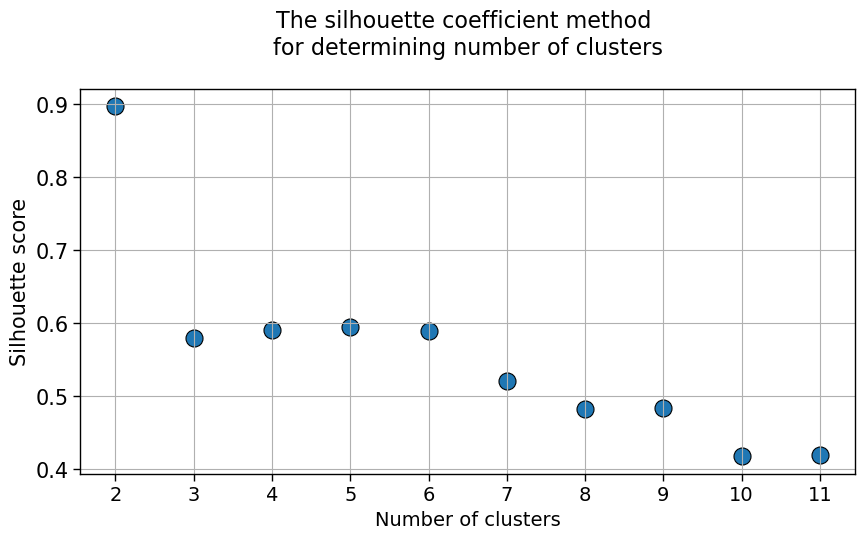

In [60]:
from sklearn.metrics import silhouette_score
wcss_silhouette = []
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0,init='k-means++').fit(rfm_table_scaled)
    preds = km.predict(rfm_table_scaled)    
    silhouette = silhouette_score(rfm_table_scaled,preds)
    wcss_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

plt.figure(figsize=(10,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=wcss_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [61]:
# kmeans = KMeans(n_clusters=3, random_state=1, init='k-means++')
# kmeans.fit(rfm_table_scaled)
# cluster_labels = kmeans.labels_
# kmeans

In [77]:
import pickle
# Save the model to a file
with open('./model/kmeans_clustering_model.pkl', 'wb') as model_file:
    pickle.dump(kmeans, model_file)

In [79]:
with open('./model/kmeans_clustering_model.pkl', 'rb') as model_file:
    kmeans = pickle.load(model_file)

kmeans

KMeans(n_clusters=3, random_state=1)

In [63]:
#create rfm segmentation table
rfm_segmentation = rfm_table.copy()
rfm_segmentation['Cluster'] = kmeans.predict(rfm_table_scaled)
rfm_segmentation

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,317,1,77183.60,0
12347.0,31,6,4085.18,1
12348.0,67,4,1797.24,1
12349.0,10,1,1757.55,1
12350.0,302,1,334.40,0
...,...,...,...,...
18280.0,269,1,180.60,0
18281.0,172,1,80.82,0
18282.0,118,1,100.21,1


In [64]:
rfm_segmentation.groupby('Cluster').mean()

,Recency,Frequency,Monetary
Cluster,,,
0,239.572068,1.580125,624.750583
1,39.700665,4.551156,1844.381553
2,6.913043,70.478261,81419.832609


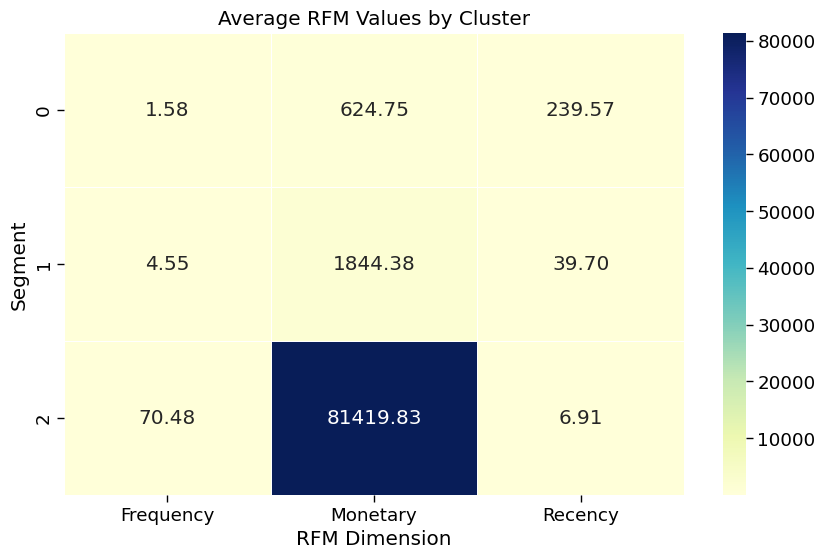

In [65]:
# Create a pivot table with the reordered segment order
pivot_table = rfm_segmentation.pivot_table(
    values=['Recency', 'Frequency', 'Monetary'],
    index='Cluster',
    aggfunc='mean'
)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    annot=True,  # Display values in each cell
    cmap='YlGnBu',  # Choose a color map
    fmt='.2f',  # Format for displaying values
    linewidths=0.5,  # Add linewidths between cells
)
plt.title('Average RFM Values by Cluster')
plt.xlabel('RFM Dimension')
plt.ylabel('Segment')
plt.show()

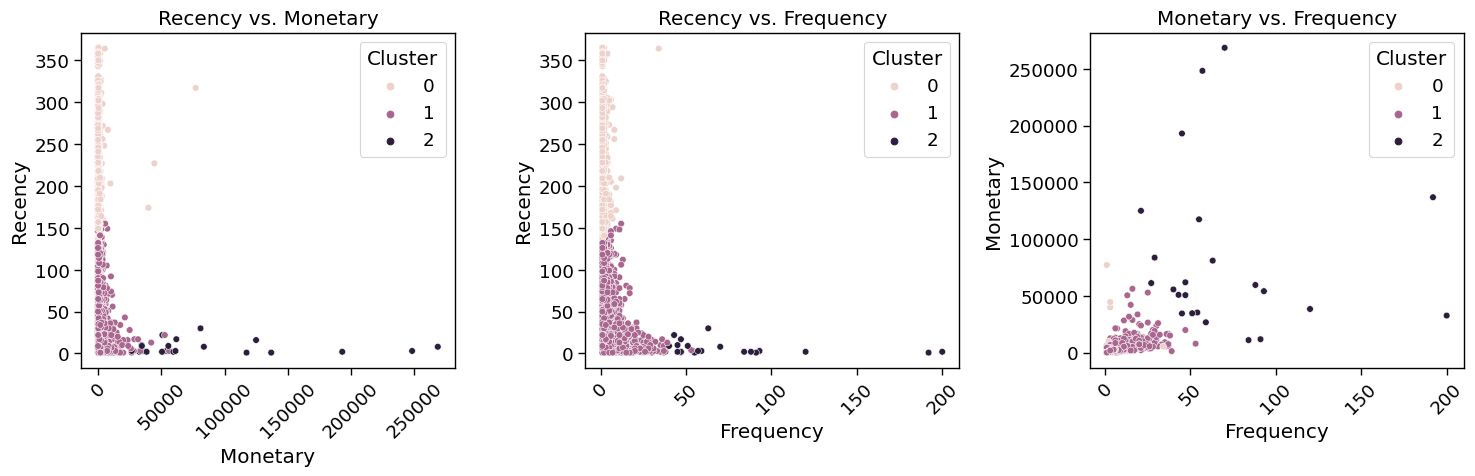

In [66]:
# Create subplots for boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colors for the bars
colors = ['lightblue', 'lightcoral', 'lightgreen']

# Boxplot of Cluster vs. Recency
sns.scatterplot(x='Frequency', y='Recency', hue='Cluster', data=rfm_segmentation, ax=axes[1])
axes[1].set_title('Recency vs. Frequency')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Recency')
axes[1].tick_params(axis='x', labelrotation=45)


# # Boxplot of Cluster vs. Frequency
sns.scatterplot(x='Monetary', y='Recency', hue='Cluster', data=rfm_segmentation, ax=axes[0])
axes[0].set_title('Recency vs. Monetary')
axes[0].set_xlabel('Monetary')
axes[0].set_ylabel('Recency')
axes[0].tick_params(axis='x', labelrotation=45)


# # Boxplot of Cluster vs. Monetary
sns.scatterplot(x='Frequency', y='Monetary',hue='Cluster', data=rfm_segmentation, ax=axes[2],)
axes[2].set_title('Monetary vs. Frequency')
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Monetary')
axes[2].tick_params(axis='x', labelrotation=45)



# Adjust layout
plt.tight_layout()

# Show the boxplots
plt.show()

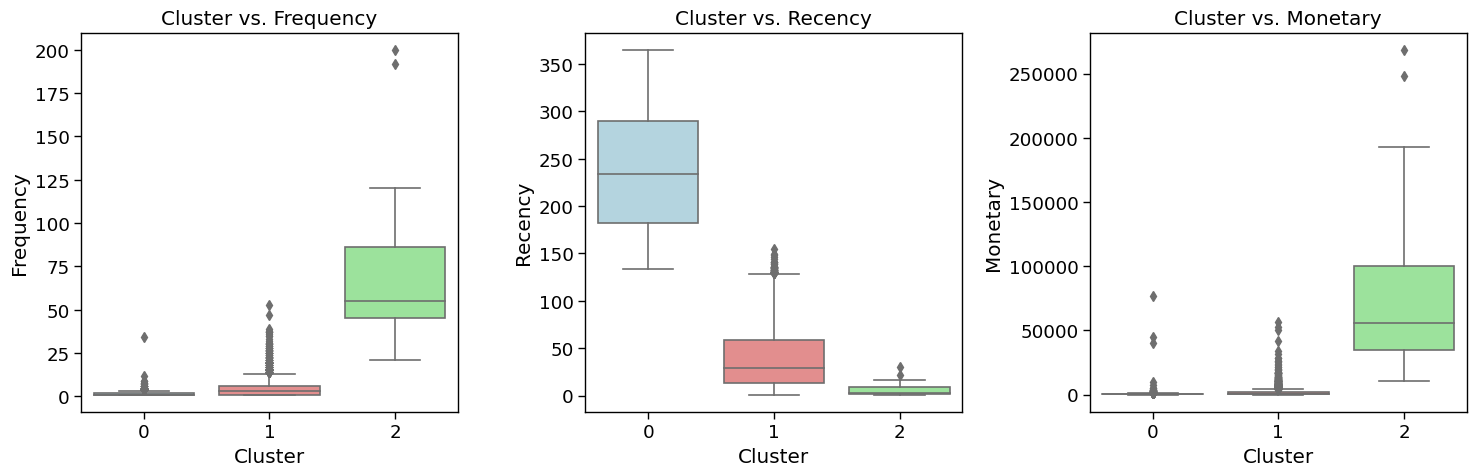

In [67]:
# Create subplots for boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colors for the bars
colors = ['lightblue', 'lightcoral', 'lightgreen']

# Boxplot of Cluster vs. Recency
sns.boxplot(x='Cluster', y='Recency', data=rfm_segmentation, ax=axes[1], palette=colors)
axes[1].set_title('Cluster vs. Recency')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Recency')

# Boxplot of Cluster vs. Frequency
sns.boxplot(x='Cluster', y='Frequency', data=rfm_segmentation, ax=axes[0], palette=colors)
axes[0].set_title('Cluster vs. Frequency')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Frequency')

# Boxplot of Cluster vs. Monetary
sns.boxplot(x='Cluster', y='Monetary', data=rfm_segmentation, ax=axes[2], palette=colors)
axes[2].set_title('Cluster vs. Monetary')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Monetary')

# Adjust layout
plt.tight_layout()

# Show the boxplots
plt.show()

In [73]:
# rfm_segmentation[['Cluster']].to_csv('./result/customer-segmentation.csv', index_label='CustomerID')